In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ot
import os
import sys
from sklearn.model_selection import train_test_split

## Prepare the data

In [2]:
# Read in the data
df40 = pd.read_csv('data/station_40.csv', index_col=0)
df49 = pd.read_csv('data/station_49.csv', index_col=0)
df63 = pd.read_csv('data/station_63.csv', index_col=0)
df80 = pd.read_csv('data/station_80.csv', index_col=0)

In [3]:
df40.columns = df40.columns.to_numpy() + '_s40'
df49.columns = df49.columns.to_numpy() + '_s49'
df63.columns = df63.columns.to_numpy() + '_s63'
df80.columns = df80.columns.to_numpy() + '_s80'

In [4]:
data = pd.concat([df40, df49, df63, df80], axis=1)
data = data.reindex(columns=sorted(data.columns))

In [5]:
T_times = list(range(1,10))
T = 0
for i in T_times:
    T += data[f'W_{i}_s40']+data[f'W_{i}_s49']+data[f'W_{i}_s63']+data[f'W_{i}_s80']
T /= 4*len(T_times)

In [6]:
data['T'] = T

In [7]:
R_times = list(range(13,16))
R = 0
for i in R_times:
    R += data[f'W_{i}_s40']+data[f'W_{i}_s49']+data[f'W_{i}_s63']+data[f'W_{i}_s80']
R /= 4*len(R_times)

In [8]:
data['R'] = R

In [9]:
#Separate the data for each scenario
Scenarios = list(range(1,10))
data_scenarios = []
Ts = [-np.inf, 21.2, 22, np.inf]
Rs = [-np.inf, 1.8, 2.2, np.inf]
for i in range(len(Rs)-1):
    for j in range(len(Ts)-1):
        data_scenarios.append(data[(data['R'] > Rs[i]) & (data['R'] < Rs[i+1]) & (data['T'] > Ts[j]) & (data['T'] < Ts[j+1])])

In [10]:
Yield_scenarios = [data_scenarios[i][["YIELD_s40", "YIELD_s49", "YIELD_s63", "YIELD_s80"]] for i in range(len(data_scenarios))]

In [11]:
Y_scenarios = [Yield_scenarios[i].to_numpy() for i in range(len(Yield_scenarios))]

In [12]:
def correction(Y):
    Y_centered = Y - np.mean(Y, axis=0)
    Y_corrected = Y_centered / np.max(abs(Y_centered), axis=0)
    print(np.mean(Y, axis=0))
    print(np.max(abs(Y_centered), axis=0))
    return Y_corrected

Y_corrected_scenarios = [correction(Y_scenarios[i]) for i in range(len(Y_scenarios))]

[10.08390086  5.88592672  0.53159483  5.15767241]
[6.11390086 7.38407328 1.87840517 3.94232759]
[10.10431783  5.83269767  2.24388372  6.44448062]
[7.20431783 6.60730233 3.59611628 6.45551938]
[9.89976758 5.96965435 4.81159714 7.32730036]
[5.98976758 5.91034565 9.22840286 8.42269964]
[11.54636704  6.71016854  0.60088015  5.67779026]
[7.50636704 6.59983146 1.96911985 5.67779026]
[11.46702552  6.74348485  2.41102871  7.34082935]
[6.98702552 6.38651515 3.75897129 7.34082935]
[11.27729205  6.8071719   5.30195933  8.62778189]
[6.54729205 6.8071719  8.77804067 8.62778189]
[12.79460775  8.07350546  0.55963257  6.18543198]
[8.73460775 7.26649454 2.20036743 4.75456802]
[12.71598817  7.79389349  2.5603787   8.36084615]
[8.27598817 7.95610651 3.1596213  8.36084615]
[12.4969031   7.56287712  5.43201798  9.66476523]
[7.4169031  7.44712288 7.24798202 9.66476523]


In [23]:
# Create the label column
labels = np.repeat(np.arange(len(Y_corrected_scenarios)), [len(Y_corrected_scenarios[i]) for i in range(len(Y_corrected_scenarios))])
labels+=1


In [27]:
concatenated_vectors = np.concatenate(Y_corrected_scenarios, axis=0)

In [32]:
concatenated_vectors.shape

(10000, 4)

In [37]:
labels = labels.reshape(10000,1)

In [38]:
Y_labeled = np.concatenate([concatenated_vectors,labels], axis=1)

In [13]:
def dist(X,Y,n_projections=1000):
    n = len(Y)
    a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

    l = ot.sliced_wasserstein_distance(X, Y, a, b, n_projections, seed=np.array(range(50)))
    return np.mean(l)

In [41]:
def split(Y):
    Ytrain, Ytest = train_test_split(Y, test_size=0.25)
    return Ytrain, Ytest

# Split the data into train and test sets
Ytrain_test_scenarios = [split(Y_corrected_scenarios[i]) for i in range(len(Y_corrected_scenarios))]

# Print the shapes of the train and test sets
print("Train set shapes:", [Ytrain_test_scenarios[i][0].shape for i in range(len(Ytrain_test_scenarios))])
print("Test set shapes:", [Ytrain_test_scenarios[i][1].shape for i in range(len(Ytrain_test_scenarios))])

Train set shapes: [(348, 4), (967, 4), (1258, 4), (400, 4), (940, 4), (811, 4), (755, 4), (1267, 4), (750, 4)]
Test set shapes: [(116, 4), (323, 4), (420, 4), (134, 4), (314, 4), (271, 4), (252, 4), (423, 4), (251, 4)]


## Prediction (side idea, not important !!)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
class YieldPredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(YieldPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [578]:
# Define hyperparameters
input_dim = 72//4
hidden_dim = 100
output_dim = 1
num_epochs = 20000
learning_rate = 0.00005

# Initialize the model
model = YieldPredictionModel(input_dim, hidden_dim, output_dim).to(device)

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert the data into PyTorch tensors
Xtrain = torch.from_numpy(predXtrain[:,1::4]).float().to(device)
Ytrain = torch.from_numpy(predYtrain[:,1].reshape(-1,1)).float().to(device)
Xtest = torch.from_numpy(predXtest[:,1::4]).float().to(device)
Ytest = torch.from_numpy(predYtest[:,1].reshape(-1,1)).float().to(device)

# Train the model
losses = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(Xtrain)
    loss = criterion(outputs, Ytrain)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        L = criterion(model(Xtest), Ytest).to('cpu').detach().numpy()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, L))
        losses.append(L)

Epoch [1000/20000], Loss: 3.7165
Epoch [2000/20000], Loss: 1.7862
Epoch [3000/20000], Loss: 1.2428
Epoch [4000/20000], Loss: 1.1963
Epoch [5000/20000], Loss: 1.1638
Epoch [6000/20000], Loss: 1.1224
Epoch [7000/20000], Loss: 1.1031
Epoch [8000/20000], Loss: 1.0969
Epoch [9000/20000], Loss: 1.0981
Epoch [10000/20000], Loss: 1.0978
Epoch [11000/20000], Loss: 1.0977
Epoch [12000/20000], Loss: 1.0968
Epoch [13000/20000], Loss: 1.0936
Epoch [14000/20000], Loss: 1.0902
Epoch [15000/20000], Loss: 1.0897
Epoch [16000/20000], Loss: 1.0894
Epoch [17000/20000], Loss: 1.0933
Epoch [18000/20000], Loss: 1.0970
Epoch [19000/20000], Loss: 1.1005
Epoch [20000/20000], Loss: 1.1020


In [577]:
savmodel = model

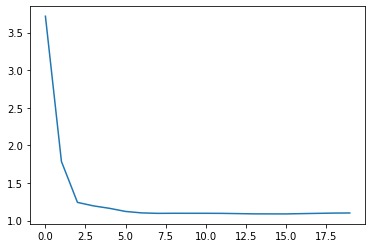

In [579]:
# Plot the loss function
plt.plot(losses)

tensor(1.1020, device='cuda:0', grad_fn=<MseLossBackward0>)


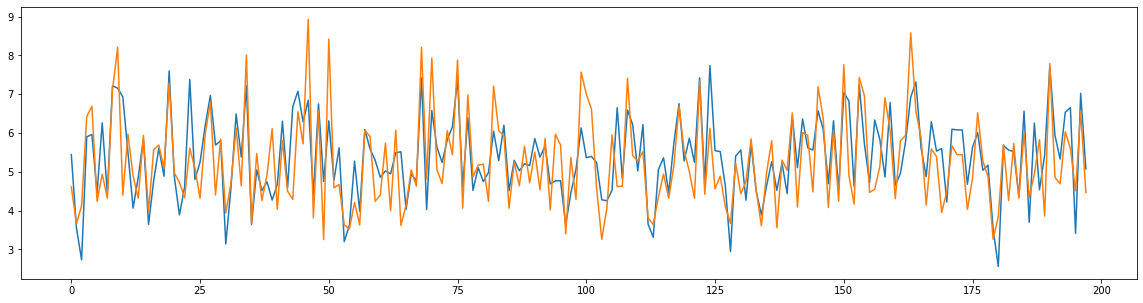

In [580]:
# Test the model
print(criterion(model(Xtest), Ytest))

fig, axs = plt.subplots(1, 1, figsize=(20, 5))
resY = torch.Tensor.cpu(Ytest).detach().numpy().flatten()[lidtest]
resX = torch.Tensor.cpu(model(Xtest)).detach().numpy().flatten()[lidtest]

plt.plot(resX[:200])
plt.plot(resY[:200])

198


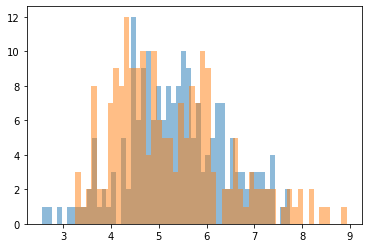

In [581]:
plt.hist(resX,bins=50,alpha=0.5)
plt.hist(resY,bins=50,alpha=0.5)
print(len(resX))

(array([ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  4.,  1.,  7.,  2.,  1.,
         3.,  1.,  0.,  2.,  2.,  7.,  3.,  4.,  2.,  4.,  9.,  4.,  4.,
         7., 13.,  8., 11.,  4.,  5.,  6.,  7.,  6.,  7.,  7.,  7., 11.,
         2.,  5., 10.,  3.,  5.,  2.,  3.,  3.,  1.,  0.,  1.]),
 array([ 4.27  ,  4.4416,  4.6132,  4.7848,  4.9564,  5.128 ,  5.2996,
         5.4712,  5.6428,  5.8144,  5.986 ,  6.1576,  6.3292,  6.5008,
         6.6724,  6.844 ,  7.0156,  7.1872,  7.3588,  7.5304,  7.702 ,
         7.8736,  8.0452,  8.2168,  8.3884,  8.56  ,  8.7316,  8.9032,
         9.0748,  9.2464,  9.418 ,  9.5896,  9.7612,  9.9328, 10.1044,
        10.276 , 10.4476, 10.6192, 10.7908, 10.9624, 11.134 , 11.3056,
        11.4772, 11.6488, 11.8204, 11.992 , 12.1636, 12.3352, 12.5068,
        12.6784, 12.85  ]),
 <BarContainer object of 50 artists>)

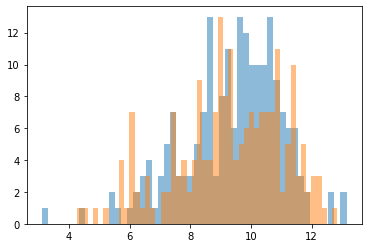

In [575]:
plt.hist(torch.Tensor.cpu(savmodel(torch.Tensor(predXtest[:,::4]).to(device))).detach().numpy().flatten()[lidtest],bins=50,alpha=0.5)
plt.hist(predYtest[:,0][lidtest],bins=50,alpha=0.5)

198


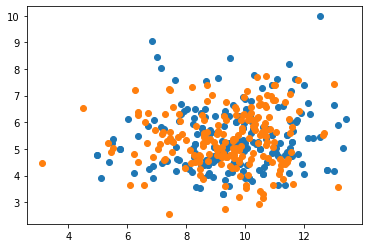

In [610]:
Y1 = torch.Tensor.cpu(savmodel(torch.Tensor(predXtest[:,::4]).to(device))).detach().numpy().flatten()[lidtest]
Y2 = torch.Tensor.cpu(model(torch.Tensor(predXtest[:,1::4]).to(device))).detach().numpy().flatten()[lidtest]
subY = Y[np.random.randint(0, len(Y), len(Y1))][:,:2]
plt.scatter(subY[:,0],subY[:,1])

print(len(Y1))
plt.scatter(Y1,Y2)

In [609]:
dist(subY, np.concatenate((Y1.reshape(-1,1),Y2.reshape(-1,1)),axis=1))

0.30795352140343385

# GENERATION

## Torch

In [42]:
# Define the generator model
class Generator(nn.Module):
    def __init__(self, latent_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        self.output_dim = output_dim

        self.model = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128, momentum=0.8),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(256, momentum=0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(512, momentum=0.8),
            nn.Linear(512, output_dim),
            nn.Softplus()
        )

    def forward(self, noise, condition):
        input = torch.cat((noise, condition), dim=1)
        return self.model(input)

# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input, condition):
        input = torch.cat((input, condition), dim=1)
        return self.model(input)

# Define the GAN model
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator.trainable = False

    def forward(self, noise, condition):
        generated_data = self.generator(noise, condition)
        discriminator_output = self.discriminator(generated_data, condition)
        return discriminator_output

# Compile the discriminator
def compile_discriminator(discriminator, learning_rate=0.001, beta_1=0.5):
    optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_1, 0.90))
    criterion = nn.BCELoss()
    return optimizer, criterion

# Compile the GAN
def compile_gan(gan, learning_rate=0.00001, beta_1=0.5):
    optimizer = torch.optim.Adam(gan.generator.parameters(), lr=learning_rate, betas=(beta_1, 0.90))
    criterion = nn.BCELoss()
    return optimizer, criterion

# Generate random noise for the generator
def generate_noise(samples, latent_dim):
    return torch.randn(samples, latent_dim)

# Generate synthetic data using the trained generator
def generate_data(generator, samples, latent_dim, condition):
    noise = generate_noise(samples, latent_dim).to(device)
    generated_data = generator(noise, condition)
    return torch.Tensor.cpu(generated_data.detach()).numpy()

# Plot generated and real data
def plot_generated_data(real_data, generated_data):
    plt.scatter(real_data[:, -4], real_data[:, -3], color='blue', label='Real Data')
    plt.scatter(generated_data[:, -4], generated_data[:, -3], color='red', label='Generated Data')
    plt.legend()
    plt.show()

def run(epochs,real_data,batch_size,latent_dim,generator,d_optimizer,d_criterion,discriminator,gan,gan_optimizer,gan_criterion,test,condition_dim=9,show = True):
    savlossD = []
    savlossW = []
    savlossG = []

    # Training loop
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_samples = torch.FloatTensor(real_data[idx]).to(device)  # Send real_samples to device
        noise = generate_noise(batch_size, latent_dim).to(device)
        labels = np.random.randint(0, condition_dim+1, batch_size)
        fake_samples = generator(noise, labels)
        real_labels = torch.ones(batch_size, 1).to(device)  # Send real_labels to device
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Send fake_labels to device

        d_optimizer.zero_grad()
        d_loss_real = d_criterion(discriminator(real_samples), real_labels)
        d_loss_fake = d_criterion(discriminator(fake_samples.detach()), fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        noise = generate_noise(batch_size, latent_dim).to(device)
        valid_labels = torch.ones(batch_size, 1).to(device)  # Send valid_labels to device

        gan_optimizer.zero_grad()
        g_loss = gan_criterion(gan(noise), valid_labels)
        g_loss.backward()
        gan_optimizer.step()

        if show:
            # Print progress and plot generated data every 100 epochs
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
                savlossD.append(d_loss.item())
                savlossG.append(g_loss.item())
                generated_data = generate_data(generator, 500, latent_dim,)
                plot_generated_data(real_data, generated_data)
                generated_data = generate_data(generator, test.shape[0], latent_dim)
                w = dist(test,generated_data)
                savlossW.append(w)
                print(w)
    if not(show):
        generated_data = generate_data(generator, test.shape[0], latent_dim)
        w = dist(test,generated_data)
        print(w)
        return w
    else:
        return savlossD, savlossG, savlossW
    
def defineandtrain(real_data,test,latent_dim=40, condition_dim=9, epochs = 400, show = True):
    # Hyperparameters
    batch_size = 128

    # Generate synthetic 2D data (replace this with your actual data)
    nsamples = len(real_data)
    ndim = real_data.shape[1]
    # Initialize models
    generator = Generator(latent_dim, condition_dim, ndim).to(device)
    discriminator = Discriminator(ndim, condition_dim).to(device)
    gan = GAN(generator, discriminator).to(device)

    # Compile models
    d_optimizer, d_criterion = compile_discriminator(discriminator)
    gan_optimizer, gan_criterion = compile_gan(gan)
    return run(epochs,real_data,batch_size,latent_dim,generator,d_optimizer,d_criterion,discriminator,gan,gan_optimizer,gan_criterion,test,condition_dim,show)


In [58]:
defineandtrain(Ytrain_test_scenarios[i][0],Ytrain_test_scenarios[i][1],latent_dim=40, epochs = 500, show = False) for i in range(len(Ytrain_test_scenarios))

0.08711405425579744
0.0901849117744755
0.08891306176378333


KeyboardInterrupt: 

<span style="color:red"> Above, we have the wasserstein distance for each scenario. Now, we have to optimize the hyperparameters independantly for each scenario.</span>

In [ ]:
### REMINDER ###
#Y_train_i = Ytrain_test_scenarios[i][0]
#Y_test_i = Ytrain_test_scenarios[i][1]

### Scenario 1

In [60]:
Y_train_1 = Ytrain_test_scenarios[0][0]
Y_test_1 = Ytrain_test_scenarios[0][1]

In [62]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_1,Y_test_1,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.09219582402863064
epoches :  400  Latent dim:  30  score :  0.09219582402863064
0.09828976003002378
epoches :  400  Latent dim:  40  score :  0.09828976003002378
0.09913139149259469
epoches :  400  Latent dim:  50  score :  0.09913139149259469
0.09186695646788666
epoches :  600  Latent dim:  30  score :  0.09186695646788666
0.07146318420771118
epoches :  600  Latent dim:  40  score :  0.07146318420771118
0.0828884679908604
epoches :  600  Latent dim:  50  score :  0.0828884679908604
0.0891897355588675
epoches :  800  Latent dim:  30  score :  0.0891897355588675
0.08714052502095306
epoches :  800  Latent dim:  40  score :  0.08714052502095306
0.07563251453032205
epoches :  800  Latent dim:  50  score :  0.07563251453032205
0.07665045992083966
epoches :  1000  Latent dim:  30  score :  0.07665045992083966
0.07995722916975562
epoches :  1000  Latent dim:  40  score :  0.07995722916975562
0.0838582037793444
epoches :  1000  Latent dim:  50  score :  0.0838582037793444


    - epoches : 600
    - latent dim : 40

### Scenario 2

In [63]:
Y_train_2 = Ytrain_test_scenarios[1][0]
Y_test_2 = Ytrain_test_scenarios[1][1]

In [64]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_2,Y_test_2,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.08385477681936263
epoches :  400  Latent dim:  30  score :  0.08385477681936263
0.07713036034760755
epoches :  400  Latent dim:  40  score :  0.07713036034760755
0.08078360314831519
epoches :  400  Latent dim:  50  score :  0.08078360314831519
0.07816988372622241
epoches :  600  Latent dim:  30  score :  0.07816988372622241
0.073632335094
epoches :  600  Latent dim:  40  score :  0.073632335094
0.07951759294268022
epoches :  600  Latent dim:  50  score :  0.07951759294268022
0.05788609515396271
epoches :  800  Latent dim:  30  score :  0.05788609515396271
0.07094620095124572
epoches :  800  Latent dim:  40  score :  0.07094620095124572
0.07690283228657373
epoches :  800  Latent dim:  50  score :  0.07690283228657373
0.06704607227654882
epoches :  1000  Latent dim:  30  score :  0.06704607227654882
0.07641938516598006
epoches :  1000  Latent dim:  40  score :  0.07641938516598006
0.0708544739155989
epoches :  1000  Latent dim:  50  score :  0.0708544739155989


    - epoches : 800
    - latent dim : 30

### Scenario 3

In [65]:
Y_train_3 = Ytrain_test_scenarios[2][0]
Y_test_3 = Ytrain_test_scenarios[2][1]

In [66]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_3,Y_test_3,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.09030068243396155
epoches :  400  Latent dim:  30  score :  0.09030068243396155
0.09238315335597726
epoches :  400  Latent dim:  40  score :  0.09238315335597726
0.09511205728969302
epoches :  400  Latent dim:  50  score :  0.09511205728969302
0.06533310786664884
epoches :  600  Latent dim:  30  score :  0.06533310786664884
0.06649457283899946
epoches :  600  Latent dim:  40  score :  0.06649457283899946
0.09374550351498062
epoches :  600  Latent dim:  50  score :  0.09374550351498062
0.0594328503390956
epoches :  800  Latent dim:  30  score :  0.0594328503390956
0.06792799058148694
epoches :  800  Latent dim:  40  score :  0.06792799058148694
0.06168078638839402
epoches :  800  Latent dim:  50  score :  0.06168078638839402
0.052752989273134904
epoches :  1000  Latent dim:  30  score :  0.052752989273134904
0.07423459555521453
epoches :  1000  Latent dim:  40  score :  0.07423459555521453
0.06825004415511192
epoches :  1000  Latent dim:  50  score :  0.06825004415511192


    - epoches : 1000
    - latent dim : 30

### Scenario 4

In [67]:
Y_train_4 = Ytrain_test_scenarios[3][0]
Y_test_4 = Ytrain_test_scenarios[3][1]

In [68]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_4,Y_test_4,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.0911532834360376
epoches :  400  Latent dim:  30  score :  0.0911532834360376
0.09443351275924874
epoches :  400  Latent dim:  40  score :  0.09443351275924874
0.10900576366192351
epoches :  400  Latent dim:  50  score :  0.10900576366192351
0.085891599078214
epoches :  600  Latent dim:  30  score :  0.085891599078214
0.09076895445939753
epoches :  600  Latent dim:  40  score :  0.09076895445939753
0.08468980604968776
epoches :  600  Latent dim:  50  score :  0.08468980604968776
0.08483136811942583
epoches :  800  Latent dim:  30  score :  0.08483136811942583
0.08924407910240016
epoches :  800  Latent dim:  40  score :  0.08924407910240016
0.08377002778995504
epoches :  800  Latent dim:  50  score :  0.08377002778995504
0.07651718466044889
epoches :  1000  Latent dim:  30  score :  0.07651718466044889
0.08710466806934389
epoches :  1000  Latent dim:  40  score :  0.08710466806934389
0.07991665530856402
epoches :  1000  Latent dim:  50  score :  0.07991665530856402


    - epoches : 1000
    - latent dim : 30

### Scenario 5

In [69]:
Y_train_5 = Ytrain_test_scenarios[4][0]
Y_test_5 = Ytrain_test_scenarios[4][1]

In [70]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_5,Y_test_5,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.0846583188065985
epoches :  400  Latent dim:  30  score :  0.0846583188065985
0.08259868287955711
epoches :  400  Latent dim:  40  score :  0.08259868287955711
0.08970348724457006
epoches :  400  Latent dim:  50  score :  0.08970348724457006
0.0599438335855348
epoches :  600  Latent dim:  30  score :  0.0599438335855348
0.07132630662334559
epoches :  600  Latent dim:  40  score :  0.07132630662334559
0.06314132942279514
epoches :  600  Latent dim:  50  score :  0.06314132942279514
0.05146003854352084
epoches :  800  Latent dim:  30  score :  0.05146003854352084
0.05434474777035995
epoches :  800  Latent dim:  40  score :  0.05434474777035995
0.051524111773481845
epoches :  800  Latent dim:  50  score :  0.051524111773481845
0.05342187931440115
epoches :  1000  Latent dim:  30  score :  0.05342187931440115
0.05718236411828113
epoches :  1000  Latent dim:  40  score :  0.05718236411828113
0.05963083318465227
epoches :  1000  Latent dim:  50  score :  0.05963083318465227


    - epoches : 800
    - latent dim : 30

### Scenario 6

In [71]:
Y_train_6 = Ytrain_test_scenarios[5][0]
Y_test_6 = Ytrain_test_scenarios[5][1]

In [72]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_6,Y_test_6,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.08623699907935882
epoches :  400  Latent dim:  30  score :  0.08623699907935882
0.07687245535569143
epoches :  400  Latent dim:  40  score :  0.07687245535569143
0.09979811213691944
epoches :  400  Latent dim:  50  score :  0.09979811213691944
0.07015582629201712
epoches :  600  Latent dim:  30  score :  0.07015582629201712
0.0647294331064578
epoches :  600  Latent dim:  40  score :  0.0647294331064578
0.07284214500635995
epoches :  600  Latent dim:  50  score :  0.07284214500635995
0.0667024973881862
epoches :  800  Latent dim:  30  score :  0.0667024973881862
0.06609749503851481
epoches :  800  Latent dim:  40  score :  0.06609749503851481
0.07308054307985361
epoches :  800  Latent dim:  50  score :  0.07308054307985361
0.07296749226464234
epoches :  1000  Latent dim:  30  score :  0.07296749226464234
0.06702523995835369
epoches :  1000  Latent dim:  40  score :  0.06702523995835369
0.05707709905539644
epoches :  1000  Latent dim:  50  score :  0.05707709905539644


    - epoches : 1000
    - latent dim : 50

### Scenario 7

In [73]:
Y_train_7 = Ytrain_test_scenarios[6][0]
Y_test_7 = Ytrain_test_scenarios[6][1]

In [74]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_7,Y_test_7,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.08648721306495256
epoches :  400  Latent dim:  30  score :  0.08648721306495256
0.09209528533753622
epoches :  400  Latent dim:  40  score :  0.09209528533753622
0.0920753065190007
epoches :  400  Latent dim:  50  score :  0.0920753065190007
0.07780328078973232
epoches :  600  Latent dim:  30  score :  0.07780328078973232
0.06870574663860889
epoches :  600  Latent dim:  40  score :  0.06870574663860889
0.07058582962974637
epoches :  600  Latent dim:  50  score :  0.07058582962974637
0.07733149011539425
epoches :  800  Latent dim:  30  score :  0.07733149011539425
0.06839552747560787
epoches :  800  Latent dim:  40  score :  0.06839552747560787
0.07296933645147698
epoches :  800  Latent dim:  50  score :  0.07296933645147698
0.05882673150468816
epoches :  1000  Latent dim:  30  score :  0.05882673150468816
0.07267540915979057
epoches :  1000  Latent dim:  40  score :  0.07267540915979057
0.09015301616794119
epoches :  1000  Latent dim:  50  score :  0.09015301616794119


    - epoches : 1000
    - latent dim : 30

### Scenario 8

In [75]:
Y_train_8 = Ytrain_test_scenarios[7][0]
Y_test_8 = Ytrain_test_scenarios[7][1]

In [76]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_8,Y_test_8,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.07873319137890203
epoches :  400  Latent dim:  30  score :  0.07873319137890203
0.07906247134384331
epoches :  400  Latent dim:  40  score :  0.07906247134384331
0.08190383227500614
epoches :  400  Latent dim:  50  score :  0.08190383227500614
0.07018064224665889
epoches :  600  Latent dim:  30  score :  0.07018064224665889
0.06761487451594499
epoches :  600  Latent dim:  40  score :  0.06761487451594499
0.07544512316765539
epoches :  600  Latent dim:  50  score :  0.07544512316765539
0.04894551112258868
epoches :  800  Latent dim:  30  score :  0.04894551112258868
0.0694856506379734
epoches :  800  Latent dim:  40  score :  0.0694856506379734
0.06594877941918208
epoches :  800  Latent dim:  50  score :  0.06594877941918208
0.06133016597596706
epoches :  1000  Latent dim:  30  score :  0.06133016597596706
0.06942501813038725
epoches :  1000  Latent dim:  40  score :  0.06942501813038725
0.05607657664898077
epoches :  1000  Latent dim:  50  score :  0.05607657664898077


    - epoches : 800
    - latent dim : 30

### Scenario 9

In [77]:
Y_train_9 = Ytrain_test_scenarios[8][0]
Y_test_9 = Ytrain_test_scenarios[8][1]

In [78]:
for e in [400,600,800,1000]:
    for ld in [30,40,50]:
        score = defineandtrain(Y_train_9,Y_test_9,latent_dim=ld, epochs = e, show = False)
        print("epoches : ", e, " Latent dim: ",ld, " score : ",score)

0.09018865329049718
epoches :  400  Latent dim:  30  score :  0.09018865329049718
0.0947498019278591
epoches :  400  Latent dim:  40  score :  0.0947498019278591
0.09519300497596772
epoches :  400  Latent dim:  50  score :  0.09519300497596772
0.06866635890188902
epoches :  600  Latent dim:  30  score :  0.06866635890188902
0.079044493685103
epoches :  600  Latent dim:  40  score :  0.079044493685103
0.0736896802244104
epoches :  600  Latent dim:  50  score :  0.0736896802244104
0.0590783222708873
epoches :  800  Latent dim:  30  score :  0.0590783222708873
0.06243665682356937
epoches :  800  Latent dim:  40  score :  0.06243665682356937
0.08597788960497271
epoches :  800  Latent dim:  50  score :  0.08597788960497271
0.06001666187596352
epoches :  1000  Latent dim:  30  score :  0.06001666187596352
0.06816824725408495
epoches :  1000  Latent dim:  40  score :  0.06816824725408495
0.06365260102731865
epoches :  1000  Latent dim:  50  score :  0.06365260102731865


    - epoches : 800
    - latent dim : 30

## results

In [51]:
def score(e,ld):
    score_scenarios = [[] for i in range(len(Y_corrected_scenarios))]
    for i in range(10):
        Y_train_test_scenarios = [split(Y_corrected_scenarios[j]) for j in range(len(Y_corrected_scenarios))]
        for j in range(len(Y_train_test_scenarios)):
            score_scenarios[j].append(defineandtrain(Y_train_test_scenarios[j][0],Y_train_test_scenarios[j][1],latent_dim=ld,epochs=e,show=False))
    return [np.mean(score_scenarios[i]) for i in range(len(score_scenarios))]

In [103]:
res = []
for e in [100,500,1000]:
    for ld in [30,40,50]:
        res.append([e,ld,score(e,ld)])

min_score_arg = min(res, key=lambda x: x[2])
print(min_score_arg)

[500, 50, 0.04469504432784296]


In [108]:
print(min_score_arg)

[500, 50, 0.04469504432784296]


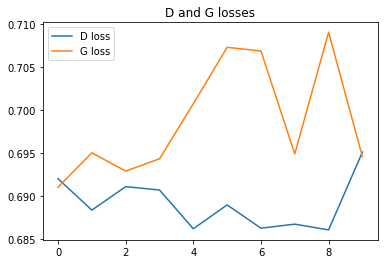

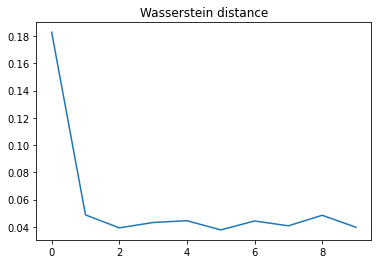

5 0.03772539178204349


In [106]:
plt.plot(savlossD,label="D loss")
plt.plot(savlossG,label="G loss")
plt.legend()
plt.title("D and G losses")
plt.show()
plt.plot(savlossW)
plt.title("Wasserstein distance")
plt.show()

print(np.argmin(savlossW),np.min(savlossW))

Meilleur sans tanh : 400,40 
MIEUX
avec : 300,50

In [112]:
latent_dim = 50
ndim = 4 
def getgen(real_data,test,latent_dim=50, epochs = 250):
    # Hyperparameters
    batch_size = 128

    # Generate synthetic 2D data (replace this with your actual data)
    nsamples = len(real_data)
    ndim = real_data.shape[1]

    # Initialize models
    generator = Generator(latent_dim, ndim).to(device)
    discriminator = Discriminator(ndim).to(device)
    gan = GAN(generator, discriminator).to(device)

    # Compile models
    d_optimizer, d_criterion = compile_discriminator(discriminator)
    gan_optimizer, gan_criterion = compile_gan(gan)
    run(epochs,real_data,batch_size,latent_dim,generator,d_optimizer,d_criterion,discriminator,gan,gan_optimizer,gan_criterion,test,False)
    return generator

In [110]:
score(250,50)

0.04654099741637243

In [131]:
Ytrain, Ytest = split(Y_corrected)
generator = getgen(Ytrain, Ytest)

In [152]:
torch.save(generator.state_dict(), 'parameters/generator_model.pth')

In [157]:
# Load the generator model
generator = Generator(latent_dim, ndim).to(device)
generator.load_state_dict(torch.load('parameters/generator_model.pth'))

<All keys matched successfully>

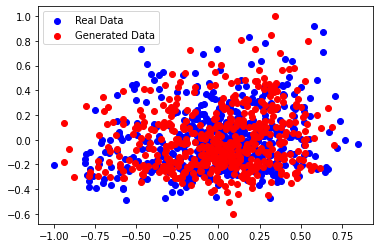

0.026444507906081962


In [158]:
Ysampled, Ysampled2 = train_test_split(Y_corrected, test_size=0.5)

plot_generated_data(Ysampled, Ysampled2)
print(dist(Ysampled, Ysampled2))

0.025914887655501682


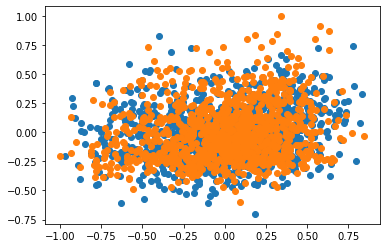

In [194]:
generated_data = generate_data(generator, 1000, latent_dim)
plt.scatter(generated_data[:, 0], generated_data[:, 1])
plt.scatter(Y_corrected[:, 0], Y_corrected[:, 1])

print(dist(Y_corrected, generated_data))


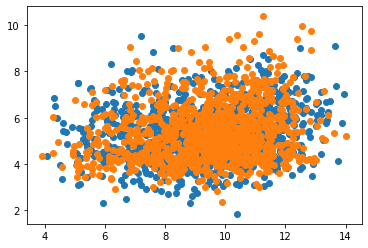

In [195]:
meancorrection = np.array([9.38902,5.36495,3.31693,6.16897])
varcorrection = np.array([5.47902, 5.01505, 6.30307, 6.16897])

generated_data = generated_data * varcorrection + meancorrection
newY = Y_corrected * varcorrection + meancorrection

plt.scatter(generated_data[:,0],generated_data[:,1])
#plt.scatter(newY[:,0],newY[:,1])
plt.scatter(Y[:,0],Y[:,1])

In [197]:
dist(Y,generated_data)

0.1503746770682202

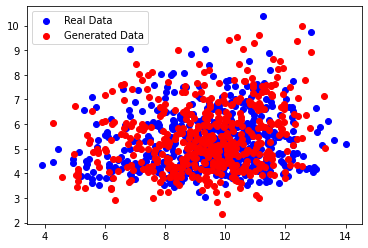

0.17385533826330363


In [199]:
Ysampled, Ysampled2 = train_test_split(Y, test_size=0.5)

plot_generated_data(Ysampled, Ysampled2)
print(dist(Ysampled, Ysampled2))

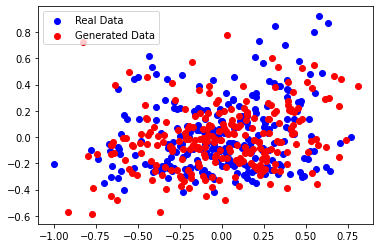

0.03930142779007523


In [47]:
generated_data = generate_data(generator, 250, latent_dim)
plot_generated_data(KMtest, generated_data)
print(dist(KMtest[:,-4:], generated_data[:,-4:]))

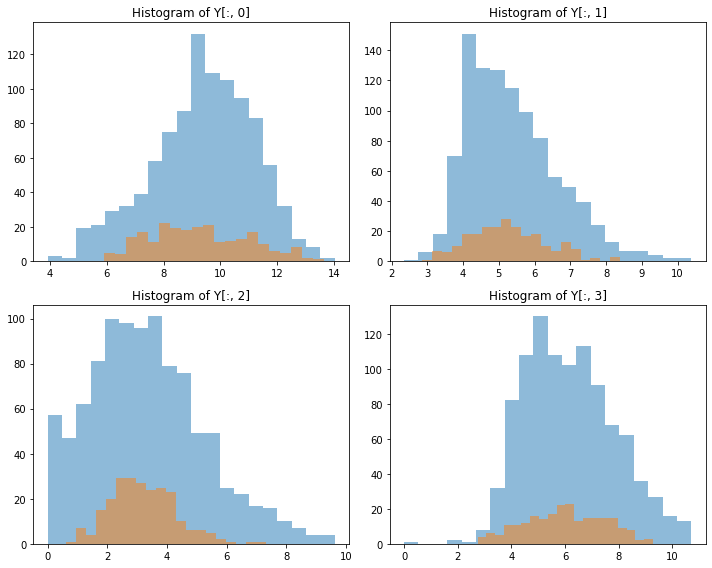

In [346]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(Y[:, 0], bins=20,alpha=0.5)
axs[0, 0].hist(gendata_corrected[:, 0], bins=20,alpha=0.5)
axs[0, 0].set_title('Histogram of Y[:, 0]')

axs[0, 1].hist(Y[:, 1], bins=20,alpha=0.5)
axs[0, 1].hist(gendata_corrected[:, 1], bins=20,alpha=0.5)
axs[0, 1].set_title('Histogram of Y[:, 1]')

axs[1, 0].hist(Y[:, 2], bins=20,alpha=0.5)
axs[1, 0].hist(gendata_corrected[:, 2], bins=20,alpha=0.5)
axs[1, 0].set_title('Histogram of Y[:, 2]')

axs[1, 1].hist(Y[:, 3], bins=20,alpha=0.5)
axs[1, 1].hist(gendata_corrected[:, 3], bins=20,alpha=0.5)
axs[1, 1].set_title('Histogram of Y[:, 3]')

plt.tight_layout()
plt.show()

# LOSS

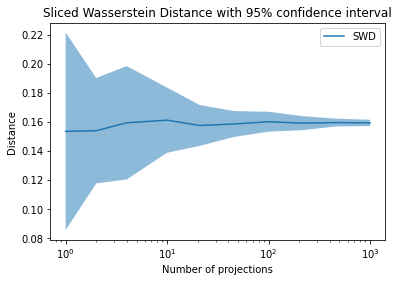

In [90]:
n = len(Y)
n_seed = 20
n_projections_arr = np.logspace(0, 3, 10, dtype=int)
res = np.empty((n_seed, 10))

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

for seed in range(n_seed):
    for i, n_projections in enumerate(n_projections_arr):
        res[seed, i] = ot.sliced_wasserstein_distance(Y, gendata_corrected, a, b, n_projections, seed=seed)

res_mean = np.mean(res, axis=0)
res_std = np.std(res, axis=0)

plt.figure(2)
plt.plot(n_projections_arr, res_mean, label="SWD")
plt.fill_between(n_projections_arr, res_mean - 2 * res_std, res_mean + 2 * res_std, alpha=0.5)

plt.legend()
plt.xscale('log')

plt.xlabel("Number of projections")
plt.ylabel("Distance")
plt.title('Sliced Wasserstein Distance with 95% confidence interval')

plt.show()